**Dependencies and setup**

This can take a minute or so...

In [1]:
%%capture
!pip install setuptools==65.5.0 "wheel<0.40.0"
!apt update
!apt-get install python3-opengl
!apt install xvfb -y
!pip install 'swig'
!pip install 'pyglet==1.5.27'
!pip install 'gym[box2d]==0.20.0'
!pip install 'pyvirtualdisplay==3.0'
!pip install torch
!pip install matplotlib

In [2]:
!pip list

Package                   Version    
------------------------- -----------
anyio                     4.3.0      
argon2-cffi               23.1.0     
argon2-cffi-bindings      21.2.0     
asttokens                 2.4.1      
async-lru                 2.0.4      
attrs                     23.2.0     
Babel                     2.14.0     
backcall                  0.2.0      
beautifulsoup4            4.12.3     
bleach                    6.1.0      
box2d-py                  2.3.5      
certifi                   2024.2.2   
cffi                      1.16.0     
charset-normalizer        3.3.2      
cloudpickle               3.0.0      
comm                      0.2.2      
contourpy                 1.1.1      
cycler                    0.12.1     
debugpy                   1.8.1      
decorator                 5.1.1      
defusedxml                0.7.1      
exceptiongroup            1.2.1      
executing                 2.0.1      
fastjsonschema            2.19.1     
filelock    

In [3]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
import copy
from collections import namedtuple, deque
from pyvirtualdisplay import Display
from IPython import display as disp
import os
import time
%matplotlib inline

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 25 # videos can take a very long time to render so only do it every N episodes

**Reinforcement learning agent**

Replace this with your own agent - I recommend starting with TD3 (lecture 8)

The implementation relies on the TD3-FORK GitHub, accessed here: https://github.com/honghaow/FORK/blob/master/BipedalWalkerHardcore/TD3_FORK_BipedalWalkerHardcore_Colab.ipynb

In [4]:
# Actor Neural Network
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc_units=400, fc1_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.torch.tanh(self.fc3(x))

# Q1-Q2-Critic Neural Network  
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Q1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc1_units)
        self.l2 = nn.Linear(fc1_units, fc2_units)
        self.l3 = nn.Linear(fc2_units, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc1_units)
        self.l5 = nn.Linear(fc1_units, fc2_units)
        self.l6 = nn.Linear(fc2_units, 1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xa))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)

        return x1, x2


class SysModel(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        super(SysModel, self).__init__()
        self.l1 = nn.Linear(state_size + action_size, fc1_units)
        self.l2 = nn.Linear(fc1_units, fc2_units)
        self.l3 = nn.Linear(fc2_units, state_size)


    def forward(self, state, action):
        """Build a system model to predict the next state at a given state."""
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        return x1

In [5]:
class TD3_FORK:
    def __init__(
        self,name,env,
        load = False,
        gamma = 0.99, #discount factor
        lr_actor = 3e-4,
        lr_critic = 3e-4,
        lr_sysmodel = 3e-4,
        batch_size = 200,
        buffer_capacity = 1000000,
        tau = 0.02,  #target network update factor
        random_seed = np.random.randint(1,10000),
        cuda = True,
        policy_noise=0.2, 
        std_noise = 0.1,
        noise_clip=0.5,
        policy_freq=3 #target network update period
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.env = env
        self.create_actor()
        self.create_critic()
        self.create_sysmodel()
        self.act_opt = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.sys_opt = optim.Adam(self.sysmodel.parameters(), lr=lr_sysmodel)
        self.set_weights()
        self.replay_memory_buffer = deque(maxlen = buffer_capacity)
        self.replay_memory_bufferd_dis = deque(maxlen = buffer_capacity)
        self.batch_size = batch_size
        self.tau = tau
        self.policy_freq = policy_freq
        self.gamma = gamma
        self.name = name
        self.upper_bound = self.env.action_space.high[0] #action space upper bound
        self.lower_bound = self.env.action_space.low[0]  #action space lower bound
        self.obs_upper_bound = self.env.observation_space.high[0] #state space upper bound
        self.obs_lower_bound = self.env.observation_space.low[0]  #state space lower bound
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.std_noise = std_noise   

    def create_actor(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0],
            'seed':            42
        }
        self.actor = Actor(**params).to(self.device)
        self.actor_target = Actor(**params).to(self.device)

    def create_critic(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0],
            'seed':            42
        }
        self.critic = Critic(**params).to(self.device)
        self.critic_target = Critic(**params).to(self.device)

    def create_sysmodel(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0]
        }
        self.sysmodel = SysModel(**params).to(self.device)

    def set_weights(self):
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

    def load_weight(self):
        self.actor.load_state_dict(torch.load('/content/drive/My Drive/bipedal/weights/hardcore/actor.pth', map_location=self.device))
        self.critic.load_state_dict(torch.load('/content/drive/My Drive/bipedal/weights/hardcore/critic.pth', map_location=self.device))
        self.actor_target.load_state_dict(torch.load('/content/drive/My Drive/bipedal/weights/hardcore/actor_t.pth', map_location=self.device))
        self.critic_target.load_state_dict(torch.load('/content/drive/My Drive/bipedal/weights/hardcore/critic_t.pth', map_location=self.device))
        self.sysmodel.load_state_dict(torch.load('/content/drive/My Drive/bipedal/weights/hardcore/sysmodel.pth', map_location=self.device))

    def add_to_replay_memory(self, transition, buffername):
        #add samples to replay memory
        buffername.append(transition)

    def get_random_sample_from_replay_mem(self, buffername):
        #random samples from replay memory
        random_sample = random.sample(buffername, self.batch_size)
        return random_sample


    def learn_and_update_weights_by_replay(self,training_iterations, weight, totrain):
        """Update policy and value parameters using given batch of experience tuples.
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        """
        # print(len(self.replay_memory_buffer))
        if len(self.replay_memory_buffer) < 1e4:
            return 1
        for it in range(training_iterations*5):
            mini_batch = self.get_random_sample_from_replay_mem(self.replay_memory_buffer)
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            add_reward_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[4] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[5] for i in mini_batch]).astype(np.uint8)).float().to(self.device)

            # Training and updating Actor & Critic networks.
            
            #Train Critic
            target_actions = self.actor_target(next_state_batch)
            offset_noises = torch.FloatTensor(action_batch.shape).data.normal_(0, self.policy_noise).to(self.device)

            #clip noise
            offset_noises = offset_noises.clamp(-self.noise_clip, self.noise_clip)
            target_actions = (target_actions + offset_noises).clamp(self.lower_bound, self.upper_bound)

            #Compute the target Q value
            Q_targets1, Q_targets2 = self.critic_target(next_state_batch, target_actions)
            Q_targets = torch.min(Q_targets1, Q_targets2)
            Q_targets = reward_batch + self.gamma * Q_targets * (1 - done_list)

            #Compute current Q estimates
            current_Q1, current_Q2 = self.critic(state_batch, action_batch)
            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, Q_targets.detach()) + F.mse_loss(current_Q2, Q_targets.detach())
            # Optimize the critic
            self.crt_opt.zero_grad()
            critic_loss.backward()
            self.crt_opt.step()

            self.soft_update_target(self.critic, self.critic_target)


            #Train_sysmodel
            predict_next_state = self.sysmodel(state_batch, action_batch) * (1-done_list)
            next_state_batch = next_state_batch * (1 -done_list)
            sysmodel_loss = F.mse_loss(predict_next_state, next_state_batch.detach())
            self.sys_opt.zero_grad()
            sysmodel_loss.backward()
            self.sys_opt.step()
        
            s_flag = 1 if sysmodel_loss.item() < 0.020  else 0

            #Train Actor
            # Delayed policy updates
            if it % self.policy_freq == 0 and totrain == 1:
                actions = self.actor(state_batch)
                actor_loss1,_ = self.critic_target(state_batch, actions)
                actor_loss1 =  actor_loss1.mean()
                actor_loss =  - actor_loss1 

                if s_flag == 1:
                    p_actions = self.actor(state_batch)
                    p_next_state = self.sysmodel(state_batch, p_actions).clamp(self.obs_lower_bound,self.obs_upper_bound)

                    p_actions2 = self.actor(p_next_state.detach()) * self.upper_bound
                    actor_loss2,_ = self.critic_target(p_next_state.detach(), p_actions2)
                    actor_loss2 = actor_loss2.mean() 

                    p_next_state2= self.sysmodel(p_next_state.detach(), p_actions2).clamp(self.obs_lower_bound,self.obs_upper_bound)
                    p_actions3 = self.actor(p_next_state2.detach()) * self.upper_bound
                    actor_loss3,_ = self.critic_target(p_next_state2.detach(), p_actions3)
                    actor_loss3 = actor_loss3.mean() 

                    actor_loss_final =  actor_loss - weight * (actor_loss2) - 0.5 *  weight * actor_loss3
                else:
                    actor_loss_final =  actor_loss

                self.act_opt.zero_grad()
                actor_loss_final.backward()
                self.act_opt.step()

                #Soft update target models
               
                self.soft_update_target(self.actor, self.actor_target)
                
        return sysmodel_loss.item()

    def soft_update_target(self,local_model,target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def policy(self,state):
        """select action based on ACTOR"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(state).cpu().data.numpy()
        self.actor.train()
        # Adding noise to action
        shift_action = np.random.normal(0, self.std_noise, size=self.env.action_space.shape[0])
        sampled_actions = (actions + shift_action)
        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        return np.squeeze(legal_action)


    def select_action(self,state):
        """select action based on ACTOR"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            actions = self.actor_target(state).cpu().data.numpy()
        return np.squeeze(actions)


    def eval_policy(self, env_name, seed, eval_episodes):
        eval_env = env_name
        eval_env.seed(seed + 100)

        avg_reward = 0.
        for _ in range(eval_episodes):
            state, done = eval_env.reset(), False
            while not done:
                action = self.select_action(np.array(state))
                state, reward, done, _ = eval_env.step(action)
                avg_reward += reward
        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward

**Prepare the environment and wrap it to capture videos**

In [6]:
%%capture
env = gym.make("BipedalWalker-v3")
#env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

In [7]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

print(float(env.action_space.high[0]))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cpu
1.0


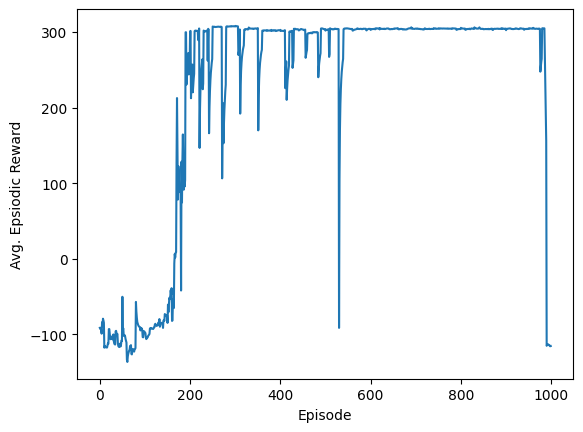

In [8]:
# in the submission please use seed 42 for verification
seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("agent-log.txt","w+")
avg_reward_list = []

# initialise agent
max_episodes = 1000
max_timesteps = 2000

# hyperparameters
BATCH_SIZE = 100
BUFFER_SIZE = 1000000

time_start = time.time()

start_timestep = 0 # time step to select action based on actor
total_timesteps = 0
sys_loss = 0
numtrainedexp = 0
save_time = 0
expcount = 0
totrain = 0
falling_down = 0

save_dir = "Models/BipedalWalker_5batch_2policy"


agent = TD3_FORK("BipedalWalkerV3", env, batch_size=BATCH_SIZE, random_seed=seed)

# training procedure:
for episode in range(1, max_episodes+1):
    state = env.reset()
    ep_reward = 0
    timestep = 0
    temp_replay_buffer = []
    
    for t in range(max_timesteps):

        # select the agent action
        if total_timesteps < start_timestep:
            action = env.action_space.sample()
        else:
            action = agent.policy(state)

        # take action in environment and get r and s'
        next_state, reward, done, _ = env.step(action)
        ep_reward += reward
        
        if reward == -100:
            add_reward = -1
            reward = -5
            falling_down += 1
            expcount += 1
        else:
            add_reward = 0
            reward = 5 * reward
            
        temp_replay_buffer.append((state, action, reward, add_reward, next_state, done))

        if done:
            if add_reward == -1 or ep_reward < 250:
                totrain = 1
                for temp in temp_replay_buffer:
                    agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
            elif expcount > 0 and np.random.rand() > 0.5:
                totrain = 1
                expcount -= 10
                for temp in temp_replay_buffer:
                    agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
            break
        
        state = next_state
        timestep += 1
        total_timesteps += 1

    # append the episode reward to the reward list
    reward_list.append(ep_reward)
    # Mean of last 100 episodes
    avg_reward = np.mean(reward_list[-100:])
    avg_reward_list.append(avg_reward)
    
    s = (int)(time.time() - time_start)
    
    #Training agent only when new experiences are added to the replay buffer
    weight =  1 - np.clip(np.mean(reward_list[-100:])/300, 0, 1)
    if totrain == 1:
        sys_loss = agent.learn_and_update_weights_by_replay(timestep, weight, totrain)
    else: 
        sys_loss = agent.learn_and_update_weights_by_replay(100, weight, totrain)
    totrain = 0
    
    # save models and loss graph every 50 episodes
    if episode % 50 == 0:
        torch.save(agent.actor.state_dict(), "{}/actor_{}.pth".format(save_dir, episode))
        torch.save(agent.critic.state_dict(), "{}/critic_{}.pth".format(save_dir, episode))
        torch.save(agent.actor_target.state_dict(), "{}/actor_target_{}.pth".format(save_dir, episode))
        torch.save(agent.critic_target.state_dict(), "{}/critic_target_{}.pth".format(save_dir, episode))
        torch.save(agent.sysmodel.state_dict(), "{}/sysmodel_{}.pth".format(save_dir, episode))
        

    # do NOT change this logging code - it is used for automated marking!
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()
    ep_reward = 0

    # print reward data every so often - add a graph like this in your report
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        with open(f"{save_dir}/reward_plot.txt", "w") as file:
            file.write(str(plot_data))
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)

        
#     print('Ep. {}, Timestep {},  Ep.Timesteps {}, Episode Reward: {:.2f}, Moving Avg.Reward: {:.2f}, Time: {:02}:{:02}:{:02} , Falling down: {}, Weight: {}'
#                 .format(episode, total_timesteps, timestep,
#                       ep_reward, avg_reward, s//3600, s%3600//60, s%60, falling_down, weight), end="\r")

# Plot episode number vs average reward
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()
env.close()

